# Darshan Analysis

Basic Notebook to perform initial analysis of a single log.

### Verify Install
Verify that importing darshan works.
If it throws an exception, probably becaues libdarshan-util.so is not found.
You can install this from the darshan repo or search for the library on your system.

> export LD_LIBRARY_PATH=<path/to/libdarshan-util.so>    

In [1]:
import darshan

In [2]:
# 
# Some other support libraries
#
import pprint
import pandas

## Point to your logfile
- Point `logfile` to your logfile of interest.
- Make sure your path is relative to where the notebook is running from

In [3]:
#logfile="examples/example-logs/shane_macsio_id29959_5-22-32552-7035573431850780836_1590156158.darshan"
logfile="examples/example-logs/sample-badost.darshan"

## Initialize the DarshanReport
This object holds the entire data of the log.

*read_all=True* will log the data from all supported records.

In [4]:
report = darshan.DarshanReport(logfile, read_all=True)

### Log Overview and Metadata
- Look at the 'Loaded Records' to see how many records are within each module.
- Look at the 'Name Records' for the total number of known file records.

In [5]:
report.info()
runtime = report.end_time - report.start_time
runtime = runtime.total_seconds()
nprocs = report.metadata['job']['nprocs']

Filename:       examples/example-logs/sample-badost.darshan
Times:          2017-06-20 17:49:39 to 2017-06-20 18:02:38 (Duration 0:12:59)
Executeable:    /global/project/projectdirs/m888/glock/tokio-abc-results/bin.edison/ior -H -k -w -o ior-posix.out -s 64 -f /global/project/projectdirs/m888/glock/tokio-abc-results/inputs/posix1m2.in
Processes:      2048
JobID:          6265799
UID:            69615
Modules in Log: ['POSIX', 'LUSTRE', 'STDIO']
Loaded Records: {'POSIX': 2048, 'STDIO': 3, 'LUSTRE': 2048}
Name Records:   2052
Darshan/Hints:  {'lib_ver': '3.1.3', 'h': 'romio_no_indep_rw=true;cb_nodes=4'}
DarshanReport:  id(140686286071984) (tmp)


## Is I/O significant for your application runtime?
- significant is usually >5% or >10%

### Average I/O per rank

POSIX_F_READ_TIME     0.000000e+00
POSIX_F_WRITE_TIME    4.298572e-02
POSIX_F_META_TIME     7.121179e-04
STDIO_F_READ_TIME     1.438199e-05
STDIO_F_WRITE_TIME    5.946297e-10
STDIO_F_META_TIME     1.735394e-04
dtype: float64


<AxesSubplot:title={'center':'Average Rank I/O Ratio'}, ylabel='Ratio'>

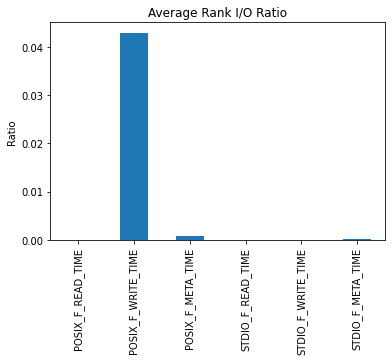

In [6]:
col_list = []
slowest = []
total_df = None

if 'POSIX' in report.modules:
    df = report.records['POSIX'].to_df()
    posix_df = pandas.merge(df['counters'], df['fcounters'], left_on=['id','rank'], right_on=['id','rank'])
    col_list += ['POSIX_F_READ_TIME', 'POSIX_F_WRITE_TIME', 'POSIX_F_META_TIME']
    slowest += ['POSIX_F_SLOWEST_RANK_TIME']
    
if 'MPI-IO' in report.modules:
    df = report.records['MPI-IO'].to_df()
    mpiio_df = pandas.merge(df['counters'], df['fcounters'], left_on=['id','rank'], right_on=['id','rank'])
    col_list += ['MPIIO_F_READ_TIME', 'MPIIO_F_WRITE_TIME', 'MPIIO_F_META_TIME']
    slowest += ['MPIIO_F_SLOWEST_RANK_TIME']


if 'STDIO' in report.modules:
    df = report.records['STDIO'].to_df()
    stdio_df = pandas.merge(df['counters'], df['fcounters'], left_on=['id','rank'], right_on=['id','rank'])
    col_list += ['STDIO_F_READ_TIME', 'STDIO_F_WRITE_TIME', 'STDIO_F_META_TIME']
    slowest += ['STDIO_F_SLOWEST_RANK_TIME']

if all(x in report.modules for x in ['POSIX', 'MPI-IO', 'STDIO']):
    total_df = pandas.merge(posix_df, mpiio_df, left_on=['id','rank'], right_on=['id','rank'], how='outer')
    total_df = pandas.merge(total_df, stdio_df, left_on=['id','rank'], right_on=['id','rank'], how='outer')
elif all(x in report.modules for x in ['POSIX', 'MPI-IO']):
    total_df = pandas.merge(posix_df, mpiio_df, left_on=['id','rank'], right_on=['id','rank'], how='outer')
elif all(x in report.modules for x in ['POSIX', 'STDIO']):
    total_df = pandas.merge(posix_df, stdio_df, left_on=['id','rank'], right_on=['id','rank'], how='outer')
else:
    total_df = posix_df

aseries = total_df[col_list].sum(axis=0).divide(runtime*nprocs)
print(aseries)
aseries.plot.bar(title='Average Rank I/O Ratio',ylabel='Ratio')


### Slowest Rank I/O
Looking at average time per rank can be deceiving if your I/O is imbalanced.
- I/O is concentrated on a few ranks
- I/O storage problem effected only part of system

      POSIX_F_SLOWEST_RANK_TIME  STDIO_F_SLOWEST_RANK_TIME
rank                                                      
-1                          0.0                   0.000258
POSIX_F_READ_TIME     0.000000
POSIX_F_WRITE_TIME    0.998643
POSIX_F_META_TIME     0.000762
STDIO_F_READ_TIME     0.000000
STDIO_F_WRITE_TIME    0.000000
STDIO_F_META_TIME     0.000000
dtype: float64
rank =  1507


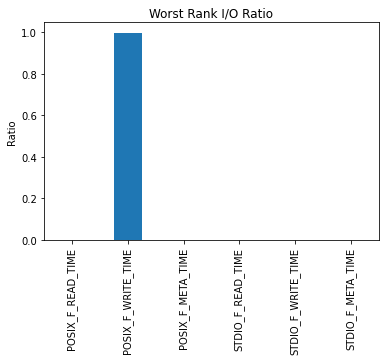

In [7]:
gtotal_df = total_df.groupby('rank')
shared_series = gtotal_df[slowest].sum().divide(runtime).head(n=1)
nonshared_series = gtotal_df[col_list].sum().divide(runtime).drop(-1)

if shared_series.shape[0] > 0:
    print(shared_series)
    #print(shared_series.max().max())
    pass

if nonshared_series.shape[0] > 0:
    #print(nonshared_series)
    print(nonshared_series.max())
    #print(nonshared_series.idxmax())
    #print(nonshared_series.shape)
    key = nonshared_series.max().idxmax()
    idx = nonshared_series.idxmax().get(key)
    print("rank = ", idx)

title='Worst Rank I/O Ratio'
ylabel='Ratio'
if shared_series.shape[0] > 0 and nonshared_series.shape[0] > 0:
    worst = nonshared_series + shared_series.max().max()
    worst.loc[idx].plot.bar(title=title,ylabel=ylabel)
elif shared_series.shape[0] > 0:
    worst = shared_series
    worst.plot.bar(title=title,ylabel=ylabel)
else:
    worst = nonshared_series
    worst.loc[idx].plot.bar(title=title,ylabel=ylabel)

#print(worst)

## Which Filesystem are your Using?
- most HPC systems have a dedicated high speed storage system, make sure you're using it.
- It's likely not you're home directory

In [8]:
total_df.loc[:,'mount'] = 'Unknown'
total_df.loc[:,'mtype'] = 'Unknown'
for index, row in total_df.iterrows():
    for m in report.mounts:
        if report.name_records[row['id']].startswith(m[0]):
            total_df.at[index, 'mount'] = m[0]
            total_df.at[index, 'mtype'] = m[1]
            break
gtotal_df = total_df.groupby('mount')
posix_list = ['POSIX_BYTES_READ', 'POSIX_BYTES_WRITTEN']
stdio_list = ['STDIO_BYTES_READ', 'STDIO_BYTES_WRITTEN']
mpiio_list = ['MPIIO_BYTES_READ', 'MPIIO_BYTES_WRITTEN']
col_list = ['mtype']
if 'POSIX' in report.modules:
    col_list += posix_list
if 'STDIO' in report.modules:
    col_list += stdio_list
if 'MPI-IO' in report.modules:
    col_list += mpiio_list
print("\t\t\tData in GiB\n\t\t\t-----------")
print(gtotal_df[col_list].sum().divide(1024*1024*1024))
print()
print('#'*20+"\nPossible Filesystems\n"+'#'*20)
pprint.pprint(report.mounts)

			Data in GiB
			-----------
                 POSIX_BYTES_READ  POSIX_BYTES_WRITTEN  STDIO_BYTES_READ  \
mount                                                                      
/global/project               0.0                  0.0          0.001541   
/scratch1                     0.0                512.0          0.000000   
Unknown                       0.0                  0.0          0.000000   

                 STDIO_BYTES_WRITTEN  
mount                                 
/global/project             0.000000  
/scratch1                   0.000000  
Unknown                     0.000002  

####################
Possible Filesystems
####################
[('/.shared/base/default/etc/dat.conf', 'dvs'),
 ('/usr/lib64/libibverbs.so.1.0.0', 'dvs'),
 ('/usr/lib64/libibumad.so.3.0.2', 'dvs'),
 ('/usr/lib64/librdmacm.so.1.0.0', 'dvs'),
 ('/usr/lib64/libibgni.so.1.0.0', 'dvs'),
 ('/global/cscratch1', 'lustre'),
 ('/global/projectb', 'dvs'),
 ('/global/projecta', 'dvs'),
 ('/usr/sbin/ibs

## File Count Sumamry
- how many files are you using? Too many?
- Consider most file systems support between 10k - 50k creates per second
- How much data is in each file? Is that sufficient to offset the create/open cost?

In [9]:
table = {}
unit = 1024*1024
t = total_df.groupby('rank').sum()
c = total_df.shape[0]
if c > 0:
    wkey = []
    rkey = []
    if 'POSIX_MAX_BYTE_WRITTEN' in t:
        wkey.append('POSIX_MAX_BYTE_WRITTEN')
        rkey.append('POSIX_MAX_BYTE_READ')
    if 'STDIO_MAX_BYTE_WRITTEN' in t:
        wkey.append('STDIO_MAX_BYTE_WRITTEN')
        rkey.append('STDIO_MAX_BYTE_READ')
    w = t[wkey].max().max() / unit
    r = t[rkey].max().max() / unit
    s = t[wkey+rkey].sum().sum() / unit
    table['total'] = { 'number': c, 'avg': s/c, 'max': max(w,r) }

def file_count(condition, key):
    t = total_df.query(condition).groupby('rank').sum()
    c = t.shape[0]
    if c > 0:
        wkey = []
        rkey = []
        if 'POSIX_MAX_BYTE_WRITTEN' in t:
            wkey.append('POSIX_MAX_BYTE_WRITTEN')
            rkey.append('POSIX_MAX_BYTE_READ')
        if 'STDIO_MAX_BYTE_WRITTEN' in t:
            wkey.append('STDIO_MAX_BYTE_WRITTEN')
            rkey.append('STDIO_MAX_BYTE_READ')
        w = t[wkey].max().max() / unit
        r = t[rkey].max().max() / unit
        s = t[wkey+rkey].sum().sum() / unit
        table[key] = { 'number': c, 'avg': s/c, 'max': max(w,r) }

condition = ""
if 'POSIX' in report.modules:
    condition += "(POSIX_READS > 0 & POSIX_WRITES <= 0)"
if 'STDIO' in report.modules:
    condition += '|' if condition else ""
    condition += "(STDIO_READS > 0 & STDIO_WRITES <= 0)"
file_count(condition, 'read-only')

condition = ""
if 'POSIX' in report.modules:
    condition += "(POSIX_WRITES > 0 & POSIX_READS <= 0)"
if 'STDIO' in report.modules:
    condition += '|' if condition else ""
    condition += "(STDIO_WRITES > 0 & STDIO_READS <= 0)"
file_count(condition, 'write-only')

condition = ""
if 'POSIX' in report.modules:
    condition += "(POSIX_WRITES > 0 & POSIX_READS > 0)"
if 'STDIO' in report.modules:
    condition += '|' if condition else ""
    condition += "(STDIO_WRITES > 0 & STDIO_READS > 0)"
file_count(condition, 'read-write')

print('#'*40+"\nFile Count Summary - Values in MiB\n"+'#'*40)
pprint.pprint(table, width=20)

########################################
File Count Summary - Values in MiB
########################################
{'read-only': {'avg': 0.0007696151733398438,
               'max': 0.0007696151733398438,
               'number': 1},
 'total': {'avg': 255.62554885979574,
           'max': 255.99999904632568,
           'number': 2051},
 'write-only': {'avg': 255.875060976977,
                'max': 255.99999904632568,
                'number': 2049}}


## I/O Operations
Next we can look at total operations count.

There isn't an absolute good or bad value for these counters. However, counts into the millions and billions
may indicate the IOP load is likely higher than desired. Look at increasing the size of I/Os to reduce the number
of operations.

High number of seeks, stats, flushes can also indicate areas that are degrading I/O performance.

<AxesSubplot:title={'center':'Total I/O Operations'}, ylabel='Count of Operations'>

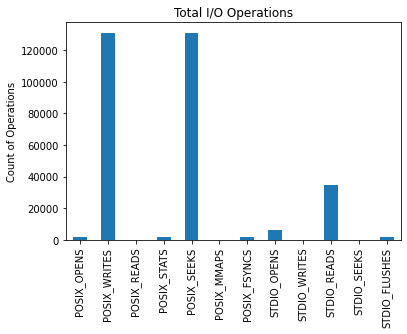

In [10]:
col_list = []
posix_list = ['POSIX_OPENS', 'POSIX_WRITES', 'POSIX_READS', 'POSIX_STATS', 'POSIX_SEEKS', 
            'POSIX_MMAPS', 'POSIX_FSYNCS']
mpiio_list = ['MPIIO_INDEP_OPENS', 'MPIIO_COLL_OPENS', 'MPIIO_INDEP_WRITES', 'MPIIO_COLL_WRITES',
              'MPIIO_INDEP_READS', 'MPIIO_COLL_READS', 'MPIIO_SYNCS']
stdio_list = ['STDIO_OPENS', 'STDIO_WRITES', 'STDIO_READS', 'STDIO_SEEKS', 'STDIO_FLUSHES']
if 'POSIX' in report.modules:
    col_list += posix_list
if 'MPI-IO' in report.modules:
    col_list += mpiio_list
if 'STDIO' in report.modules:
    col_list += stdio_list

series = total_df[col_list].sum(axis=0)
#print(series)
series.plot.bar(title='Total I/O Operations', ylabel="Count of Operations")

## I/O Access
- small i/o is usaually inieffcient unless read/write buffering done by FS
- larger sizes are usuaslly better

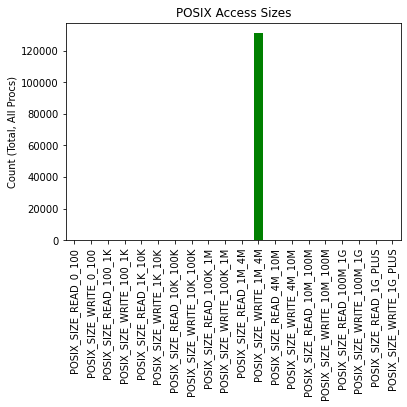

In [11]:
if 'POSIX' in report.modules:
    col_list = ['POSIX_SIZE_READ_0_100',    'POSIX_SIZE_WRITE_0_100',
                'POSIX_SIZE_READ_100_1K',   'POSIX_SIZE_WRITE_100_1K',
                'POSIX_SIZE_READ_1K_10K',   'POSIX_SIZE_WRITE_1K_10K',
                'POSIX_SIZE_READ_10K_100K', 'POSIX_SIZE_WRITE_10K_100K',
                'POSIX_SIZE_READ_100K_1M',  'POSIX_SIZE_WRITE_100K_1M',
                'POSIX_SIZE_READ_1M_4M',    'POSIX_SIZE_WRITE_1M_4M',
                'POSIX_SIZE_READ_4M_10M',   'POSIX_SIZE_WRITE_4M_10M',
                'POSIX_SIZE_READ_10M_100M', 'POSIX_SIZE_WRITE_10M_100M',
                'POSIX_SIZE_READ_100M_1G',  'POSIX_SIZE_WRITE_100M_1G',
                'POSIX_SIZE_READ_1G_PLUS',  'POSIX_SIZE_WRITE_1G_PLUS']
    series = total_df[col_list].sum(axis=0)
    series.plot.bar(title="POSIX Access Sizes", ylabel="Count (Total, All Procs)",color=['m','g'])

In [12]:
if 'MPI-IO' in report.modules:
    col_list = ['MPIIO_SIZE_READ_AGG_0_100',    'MPIIO_SIZE_WRITE_AGG_0_100',
                'MPIIO_SIZE_READ_AGG_100_1K',   'MPIIO_SIZE_WRITE_AGG_100_1K',
                'MPIIO_SIZE_READ_AGG_1K_10K',   'MPIIO_SIZE_WRITE_AGG_1K_10K',
                'MPIIO_SIZE_READ_AGG_10K_100K', 'MPIIO_SIZE_WRITE_AGG_10K_100K',
                'MPIIO_SIZE_READ_AGG_100K_1M',  'MPIIO_SIZE_WRITE_AGG_100K_1M',
                'MPIIO_SIZE_READ_AGG_1M_4M',    'MPIIO_SIZE_WRITE_AGG_1M_4M',
                'MPIIO_SIZE_READ_AGG_4M_10M',   'MPIIO_SIZE_WRITE_AGG_4M_10M',
                'MPIIO_SIZE_READ_AGG_10M_100M', 'MPIIO_SIZE_WRITE_AGG_10M_100M',
                'MPIIO_SIZE_READ_AGG_100M_1G',  'MPIIO_SIZE_WRITE_AGG_100M_1G',
                'MPIIO_SIZE_READ_AGG_1G_PLUS',  'MPIIO_SIZE_WRITE_AGG_1G_PLUS']
    series = total_df[col_list].sum(axis=0)
    series.plot.bar(title="MPI-IO Access Sizes", ylabel="Count (Total, All Procs)",color=['m','g'])